In [1]:
import numpy as np
import os
import sys
import scipy
import glob

In [2]:
sys.path.append('/home/dwu/DeepRecon/')
import helper
import DECT.HYPR_NLM.python.HYPR_NLM as HYPR_NLM
sys.path.append('../Preprocess/')
import CTPPreprocess as preprocess
import CalcParaMaps as paramaps

In [3]:
import argparse
parser = argparse.ArgumentParser(description = 'TIPS for CTP')
parser.add_argument('--imgFile', type=str, 
                    default='/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_1e+06.npy')
parser.add_argument('--refFile', type=str, 
                    default='/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_-1.npy')
parser.add_argument('--paraFile', type=str, 
                    default='/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/paras_tikh_0.3.npz')
parser.add_argument('--aifFile', type=str, 
                    default='/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/aif0.npy')
parser.add_argument('--iTest', dest='iTest', type=int, nargs=2, default=[55,56])

# paths
parser.add_argument('--outDir', dest='outDir', type=str, default=None)

parser.add_argument('--device', dest='device', type=int, default=0)
parser.add_argument('--aug', dest='aug', type=int, default=1)
parser.add_argument('--imgNorm', dest='imgNorm', type=float, default=0.15)

parser.add_argument('--windowSize', dest='windowSize', type=int, nargs=3, default=[7,7,1])
parser.add_argument('--stdTips', dest='stdTips', type=float, default=1)
parser.add_argument('--stdDist', dest='stdDist', type=float, default=2)

_StoreAction(option_strings=['--stdDist'], dest='stdDist', nargs=None, const=None, default=2, type=<class 'float'>, choices=None, help=None, metavar=None)

In [4]:
if sys.argv[0] != 'TIPS.py':
    from IPython import display
    import matplotlib.pyplot as plt
    %matplotlib inline
    args = parser.parse_args(['--device', '0',
                              '--windowSize', '11', '11', '1',
                              '--imgFile', '/home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_200000.npy',
                              '--stdTips', '0.05',
                              '--stdDist', '2',
                              '--iTest', '55', '70',
                              '--outDir', '/home/dwu/trainData/Noise2Noise/train/ctp/simul/tips/test'])
else:
    args = parser.parse_args(sys.argv[1:])

for k in args.__dict__:
    print (k, args.__dict__[k], sep=': ', flush=True)

imgFile: /home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_200000.npy
refFile: /home/dwu/trainData/Noise2Noise/train/ctp/simul/data/imgs_-1.npy
paraFile: /home/dwu/trainData/Noise2Noise/train/ctp/simul/data/paras_tikh_0.3.npz
aifFile: /home/dwu/trainData/Noise2Noise/train/ctp/simul/data/aif0.npy
iTest: [55, 70]
outDir: /home/dwu/trainData/Noise2Noise/train/ctp/simul/tips/test
device: 0
aug: 1
imgNorm: 0.15
windowSize: [11, 11, 1]
stdTips: 0.05
stdDist: 2.0


In [5]:
# load the image data
imgs = (np.load(args.imgFile)[args.iTest[0]:args.iTest[1], ...] - 1) / args.imgNorm
refs = (np.load(args.refFile)[args.iTest[0]:args.iTest[1], ...] - 1) / args.imgNorm

In [6]:
# load param maps
with np.load(args.paraFile) as f:
    cbf0 = f['cbf'][args.iTest[0]:args.iTest[1], ...]
    cbv0 = f['cbv'][args.iTest[0]:args.iTest[1], ...]
    mtt0 = f['mtt'][args.iTest[0]:args.iTest[1], ...]
    mask = f['mask'][args.iTest[0]:args.iTest[1], ...]
    cbfFac = f['cbfFac']
aif = np.load(args.aifFile) / 1000 / args.imgNorm

maskVessels = np.where(np.max(imgs, -1) > 0.1 / args.imgNorm, 1, 0)
maskVessels *= mask
for i in range(maskVessels.shape[0]):
    maskVessels[i,...] = scipy.ndimage.morphology.binary_dilation(maskVessels[i,...])
mask *= (1-maskVessels)

imgs *= np.tile(mask[...,np.newaxis], (1,1,1,imgs.shape[-1]))

In [7]:
HYPR_NLM.SetDevice(args.device)

0

In [8]:
if args.stdTips < 0:
    ssd = HYPR_NLM.TIPS(imgs[..., np.newaxis,:], args.windowSize, 0, 0, ssdOnly=1)
    ssd = np.mean(ssd, -1)
    stdTips = np.sqrt(np.sum(mask * ssd) / np.sum(mask))
else:
    stdTips = args.stdTips

recon = HYPR_NLM.TIPS(imgs[..., np.newaxis,:], args.windowSize, stdTips, args.stdDist)
recon = recon[..., 0, :] - (recon[..., 0, [0]] + recon[..., 0, [1]]) / 2

In [9]:
recon2 = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/simul/beta_12.5_N0_200000/tmp/iodines.npy')
recon2 = recon2[args.iTest[0]:args.iTest[1],...].transpose(0, 2, 3, 1)
recon2 = recon2 * 0.025 / args.imgNorm

In [10]:
def BiasCorrection(recon, src, mask):
    reconFiltered = scipy.ndimage.gaussian_filter(recon, (0, 2, 2, 0))
    srcFiltered = scipy.ndimage.gaussian_filter(src, (0, 2, 2, 0))
    bcRecon = np.zeros_like(recon)
    for iSlice in range(reconFiltered.shape[0]):
#         print (iSlice, end=',')
        ind = np.where(mask[iSlice, ...].flatten() > 0)
        for iFrame in range(reconFiltered.shape[-1]):
            x = reconFiltered[iSlice,...,iFrame].flatten()[ind]
            y = srcFiltered[iSlice,...,iFrame].flatten()[ind]
            p = np.polyfit(x, y, 1)
            bcRecon[iSlice,...,iFrame] = (p[0] * recon[iSlice,...,iFrame] + p[1]) * mask[iSlice,...,0]
    
    return bcRecon

In [14]:
ctp = imgs - (imgs[...,[0]] + imgs[...,[1]]) / 2
frameMask = np.tile(mask[...,np.newaxis], (1,1,1,ctp.shape[-1]))
bc2 = BiasCorrection(recon2 * frameMask, ctp * frameMask, mask[...,np.newaxis])

In [15]:
cbf0, cbv0, mtt0 = paramaps.CalcParaMaps(refs - refs[...,[0]], mask, aif=np.copy(aif), kappa=1, rho=1)
cbf0 *= cbfFac
mtt0 /= cbfFac

In [16]:
cbf, cbv, mtt = paramaps.CalcParaMaps(recon, mask, aif=np.copy(aif), kappa=1, rho=1)
cbf *= cbfFac
mtt /= cbfFac
rmse = np.sqrt(np.sum((cbf - cbf0)**2 * mask) / np.sum(mask))
rmseCbv = np.sqrt(np.sum((cbv - cbv0)**2 * mask) / np.sum(mask))
rmseMtt = np.sqrt(np.sum((mtt - mtt0)**2 * mask) / np.sum(mask))
print (rmse, rmseCbv, rmseMtt)

4.156609182906537 0.597710434454801 1.2103785548895138


In [17]:
cbf2, cbv2, mtt2 =  paramaps.CalcParaMaps(bc2, mask, aif=np.copy(aif), kappa=1, rho=1)
cbf2 *= cbfFac
mtt2 /= cbfFac
rmse = np.sqrt(np.sum((cbf2 - cbf0)**2 * mask) / np.sum(mask))
rmseCbv = np.sqrt(np.sum((cbv2 - cbv0)**2 * mask) / np.sum(mask))
rmseMtt = np.sqrt(np.sum((mtt2 - mtt0)**2 * mask) / np.sum(mask))
print (rmse, rmseCbv, rmseMtt)

3.5630278635711203 0.3279625807427245 0.5153415296094883


In [58]:
cbfn, cbvn, mttn =  paramaps.CalcParaMaps(ctp, mask, aif=aif, kappa=1, rho=1)
cbfn *= cbfFac
mttn /= cbfFac
rmse = np.sqrt(np.sum((cbfn - cbf0)**2 * mask) / np.sum(mask))
rmseCbv = np.sqrt(np.sum((cbvn - cbv0)**2 * mask) / np.sum(mask))
rmseMtt = np.sqrt(np.sum((mttn - mtt0)**2 * mask) / np.sum(mask))
print (rmse, rmseCbv, rmseMtt)

14.543990081664042 3.500640284655507 9.53880658445821


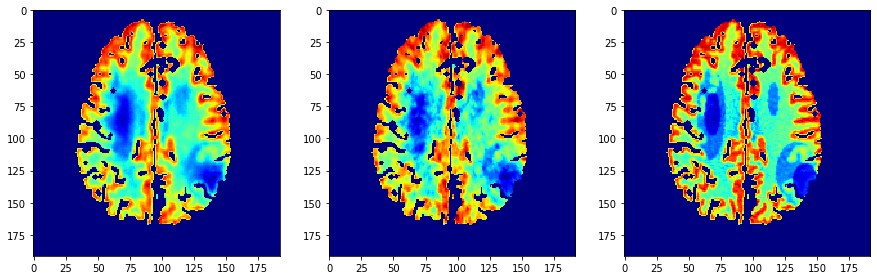

In [66]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbf2[0,32:-32, 32:-32], 'jet', vmin=0, vmax=50)
plt.subplot(132); plt.imshow(cbf[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=50)
plt.subplot(133); plt.imshow(cbf0[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=50)

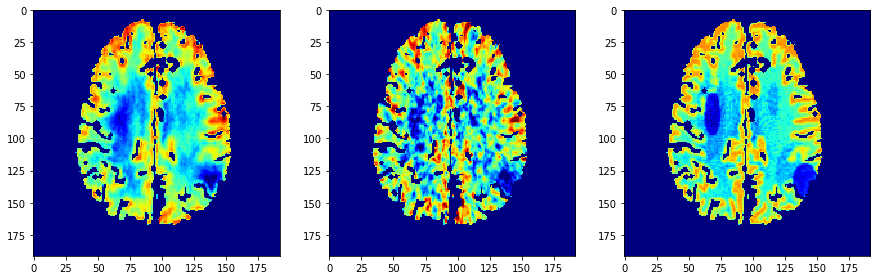

In [43]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(cbv2[0,32:-32, 32:-32], 'jet', vmin=0, vmax=4)
plt.subplot(132); plt.imshow(cbv[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=4)
plt.subplot(133); plt.imshow(cbv0[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=4)

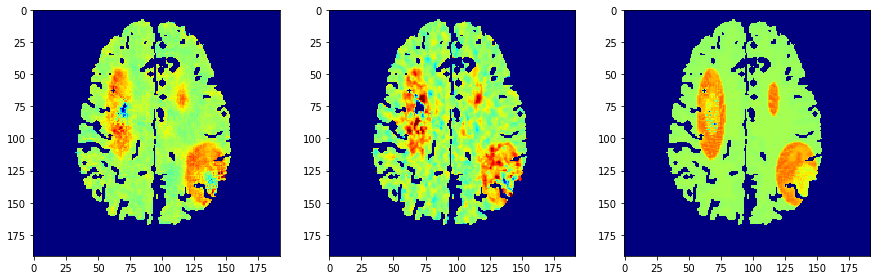

In [24]:
plt.figure(figsize=[15,5])
plt.subplot(131); plt.imshow(mtt2[0,32:-32, 32:-32], 'jet', vmin=0, vmax=7.5)
plt.subplot(132); plt.imshow(mtt[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=7.5)
plt.subplot(133); plt.imshow(mtt0[0,32:-32, 32:-32] * mask[0,32:-32, 32:-32], 'jet', vmin=0, vmax=7.5)

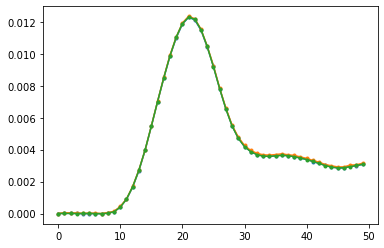

In [59]:
frameMask = np.tile(mask[...,np.newaxis], (1,1,1,recon.shape[-1]))
tac = np.mean(recon * frameMask, (0,1,2))
tac2 = np.mean(bc2 * frameMask, (0,1,2))
tac0 = np.mean((refs - refs[...,[0]]) * frameMask, (0,1,2))
plt.plot(tac, '.-')
plt.plot(tac2, '.-')
plt.plot(tac0, '.-')

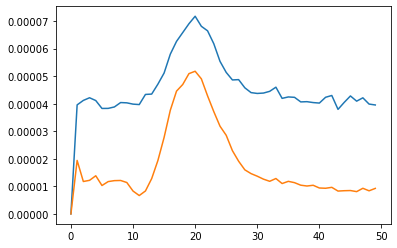

In [60]:
ctp = refs - refs[...,[0]]
allMask = np.tile(mask[...,np.newaxis], (1,1,1,recon.shape[-1]))
frameRmse = np.sum((recon - ctp)**2 * allMask, (0,1,2)) / np.sum(allMask, (0,1,2))
frameRmse2 = np.sum((bc2 - ctp)**2 * allMask, (0,1,2)) / np.sum(allMask, (0,1,2))
plt.plot(frameRmse)
plt.plot(frameRmse2)